# Inversions

In this notebook, we use a synthetic example to explore aspects of inversion including ... 

## Step 0: Imports and load survey info

These steps are the same as in the previous notebook. 

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import ipywidgets

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc

In [2]:
# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14

## Step 1: Load DC Survey

This is the same as in the previous notebook, but included so we can re-visit any of the steps as necessary. 

In [18]:
line = "46800E"

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

In [19]:
def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=np.str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [20]:
dc_data_dict = read_dcip_data(dc_data_file, verbose=False)

In [21]:
# initialize an empty list for each 
source_list = []

# center the survey and work in local coordinates
x_local = 0.5*(np.min(dc_data_dict["a_locations"]) + np.max(np.hstack(dc_data_dict["n_locations"])))

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i] - x_local, 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i] - x_local,
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs, storeProjections=False)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i] - x_local, 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i] - x_local, 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [22]:
survey = dc.Survey(source_list=source_list)

## Step 2: Build a Mesh

Similar to the previous notebook, we use a simple function to design our mesh. 

In [25]:
def build_mesh(
    survey=survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
):
    """
    A function for designing a Tensor Mesh based on DC survey parameters
    
    Parameters
    ----------
    
    survey: dc.Survey 
        A DC (or IP) survey object
    
    n_cells_per_spacing_[x, z]: int
        Number of [x, z]-cells per the minimum electrode spacing
        
    n_core_extra_[x, z]: int
        Number of extra cells with the same size as the core domain beyond the survey extent
    
    core_domain_z_ratio: float
        Factor that multiplies the maximum AB, MN seperation to define the core mesh extent
    
    padding_factor: float
        Factor by which we expand the mesh cells in the padding region
    
    n_pad_[x, z]: int
        Number of padding cells in the x, z directions
    """
    min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))

    dx = min_electrode_spacing / n_cells_per_spacing_x
    dz = min_electrode_spacing / n_cells_per_spacing_z
    
    # define the x core domain
    core_domain_x = np.r_[
        survey.electrode_locations[:, 0].min(),
        survey.electrode_locations[:, 0].max()
    ]
    
    # find the y core domain
    # find the maximum spacing between source, receiver midpoints
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    seperation_ab_mn = np.abs(mid_ab - mid_mn)
    max_seperation = seperation_ab_mn.max()
    core_domain_z = np.r_[-core_domain_z_ratio * max_seperation, 0.]
    
    # add extra cells beyond the core domain
    n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra_x*2  # on each side
    n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra_z  # just below
    
    # define the tensors in each dimension
    hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
    hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

    mesh = discretize.TensorMesh([hx, hz], x0="CN")

    return mesh, core_domain_x, core_domain_z

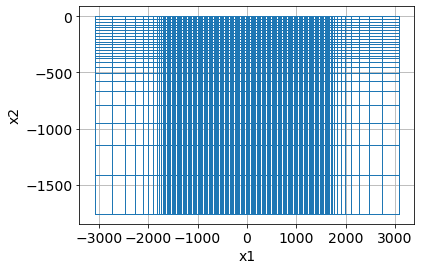

In [24]:
mesh, core_domain_x, core_domain_z = build_mesh(survey)
mesh.plotGrid()

## Step 3: Design our True Model 

Here, we will focus in on a synthetic example so we know the true solution. Again, we will use a model containing 2 blocks in a halfspace. 

### 3.1 Define the model geometry and physical properties

In [26]:
# define the resistivities
rho_background = 100
rho_resistive_block = 1000
rho_conductive_block = 10

# define the geometry of each block
xlim_resistive_block = np.r_[-500, -250]
zlim_resistive_block = np.r_[-150, -50]

xlim_conductive_block = np.r_[250, 500]
zlim_conductive_block = np.r_[-150, -50]

In [27]:
rho = rho_background * np.ones(mesh.nC)

# resistive block
inds_resistive_block = (
    (mesh.gridCC[:, 0] >= xlim_resistive_block.min()) & (mesh.gridCC[:, 0] <= xlim_resistive_block.max()) &
    (mesh.gridCC[:, 1] >= zlim_resistive_block.min()) & (mesh.gridCC[:, 1] <= zlim_resistive_block.max())
)

rho[inds_resistive_block] = rho_resistive_block

# conductive block
inds_conductive_block = (
    (mesh.gridCC[:, 0] >= xlim_conductive_block.min()) & (mesh.gridCC[:, 0] <= xlim_conductive_block.max()) &
    (mesh.gridCC[:, 1] >= zlim_conductive_block.min()) & (mesh.gridCC[:, 1] <= zlim_conductive_block.max())
)

rho[inds_conductive_block] = rho_conductive_block

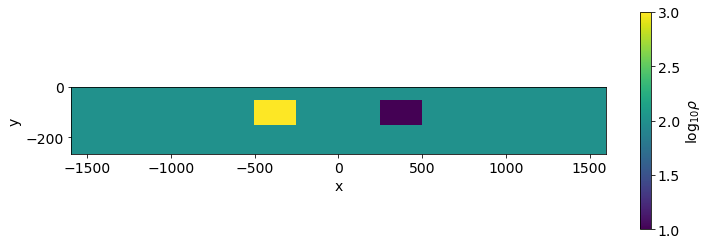

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
out = mesh.plotImage(np.log10(rho), ax=ax)
plt.colorbar(out[0], ax=ax, label="log$_{10} \\rho$")
ax.set_xlim(core_domain_x)
ax.set_ylim(core_domain_z)
ax.set_aspect(1.5)

### 3.2 Define the true model

Since we will be working with log-resistivities in the inversion, our true model is defined as the log of the resistivity. 

In [13]:
model_true = np.log(rho)

## Step 4: Set up and run a forward simulation

These will be the "observed data" in the inversion. We will not add noise to them. If you would like to add noise, you can pass `add_noise` to the `make_synthetic_data` function. 

As in the first notebook, we will invert for log-resistivity, so we use an `ExpMap` in the forward simulation. 

In [32]:
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey
)

In [33]:
%%time 

# compute our "observed data"
synthetic_data = simulation_dc.make_synthetic_data(model_true)

CPU times: user 811 ms, sys: 45.3 ms, total: 857 ms
Wall time: 265 ms


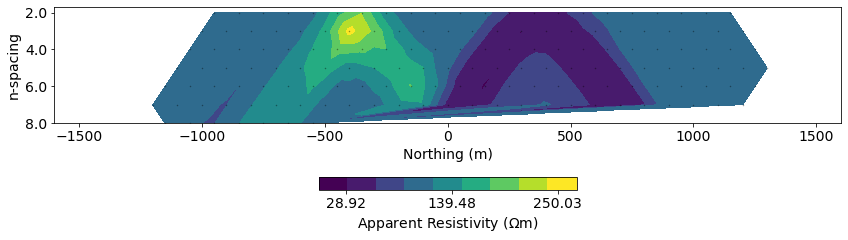

In [34]:
# plot pseudosections 
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
# plot a psuedosection of the data
dc.utils.plot_pseudosection(
    synthetic_data, data_type="apparent resistivity", 
    plot_type="contourf", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)
ax.set_xlim(core_domain_x)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_xlabel("Northing (m)")

plt.tight_layout()


---
# Recall: inversion as optimization 

We forumlate the inverse problem as an optimization problem consisting of a data misfit and a regularization 

$$
\min_{\mathbf{m}} \Phi(\mathbf{m}) = \Phi_d(\mathbf{m}) + \beta\Phi_m(\mathbf{m}) \\ s.t. ~ \Phi_d \leq \Phi_d^* \quad \mathbf{m}_i^{\rm L} \leq \mathbf{m}_ \leq \mathbf{m}_i^{\rm U}
$$

where:
- $\mathbf{m}$ is our inversion model - a vector containing the set of parameters that we invert for


- $\Phi_d$ is the data misfit
  $$
  \Phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) -    \mathbf{d}^{\text{obs}})\|^2
  $$
  

- $\Phi_m$ is the regularization
  $$
  \Phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|\mathbf{W_s} (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_x\|\mathbf{W_x} (\mathbf{m})\|^2 + \alpha_z\|\mathbf{W_z} (\mathbf{m})\|^2 \big)
  $$
  

- $\beta$ is a trade-off parameter that weights the relative importance of the data misfit and regularization terms


- $\Phi_d^*$ is our target misfit, which is typically set to $N/2$ where $N$ is the number of data (Parker, 1994) (or also see [Oldenburg & Li (2005)](https://www.researchgate.net/profile/Douglas_Oldenburg/publication/238708196_5_Inversion_for_Applied_Geophysics_A_Tutorial/links/004635282572529927000000.pdf))
---


## Step 5: assign standard deviations to the data

The standard deviations are an estimate of the level of noise on your data. These are used to construct the weights in the $\mathbf{W_d}$ matrix of the data misfit.

It is common to define the standard deviation in terms of a `relative_error` and a `noise_floor`. 

$$ \text{standard_deviation} =  \text{relative_error}\times|d^{obs}| + \text{noise_floor}$$

For DC resistivity, it is common to choose a `relative_error` between 0.02-0.1 (2% - 5% error). The `noise_floor` value defines threshold for data below which we consider those values to be close to zero. It is important to set a non-zero `noise_floor` when we can have zero-crossings in our data (e.g. both positive and negative values - which we do in DC!). The `noise_floor` ensures that we don't try to fit near-zero values to very high accuracy. It is common to choose a noise floor such that some percentage of the data fall below that floor.  

In [46]:
relative_error = 0.05  # 5% error
noise_floor = 5e-4 


Plotting a histogram of our data is a constructive way to assess what an appropriate noise floor is.

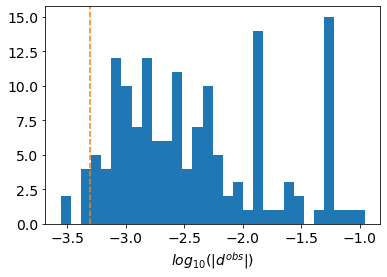

In [47]:
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(np.abs(synthetic_data.dobs)), 30)
ax.set_xlabel("$log_{10}(|d^{obs}|)$")
ax.axvline(np.log10(noise_floor), linestyle="dashed", color="C1")

In [49]:
n_data_below = np.sum(np.abs(synthetic_data.dobs) <= noise_floor)
print(f"{100*n_data_below/survey.nD:1.2f}% of data fall below the noise floor")

3.97% of data fall below the noise floor


### 5.1 Assign uncertainties to our data object

In SimPEG, the `data` object is responsible for keeping track of the survey geometry, observed data and uncertainty values. The `standard_deviation` property is what is used to construct the $\mathbf{W_d}$ matrix in the data misfit

```
W_d = diag(1 / data.standard_deviation) 
```

In [51]:
synthetic_data.relative_error = relative_error
synthetic_data.noise_floor = noise_floor

In [54]:
assert(np.allclose(
    relative_error * np.abs(synthetic_data.dobs) + noise_floor, 
    synthetic_data.standard_deviation
))

## Step 6: Assembling the inversion 

Here, we are going to set up functions for constructing and running the inversion so that we can easily adjust the parameters used in the inversion.

We start be defining a function that will construct our `inverse_problem` object which requires the `data_misfit`, `regularization`, and `optimization` be constructed. 

In [ ]:
def build_inverse_problem(
    
):
    # set up the data misfit
    dmisfit = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation_dc)
    